In [47]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dataset = load_dataset("cgarciae/point-cloud-mnist")

train_data = dataset['train']

single_datapoint = train_data[0]
point_cloud = single_datapoint['points']  
label = single_datapoint['label'] 
point_cloud = np.array(point_cloud)
print(f"Point cloud shape: {point_cloud.shape}")
print(f"Digit label: {label}")


Repo card metadata block was not found. Setting CardData to empty.


Point cloud shape: (351, 3)
Digit label: 5


In [ ]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dataset = load_dataset("cgarciae/point-cloud-mnist")

train_data = dataset['train']

single_datapoint = train_data[0]
point_cloud = single_datapoint['points']  
label = single_datapoint['label'] 
point_cloud = np.array(point_cloud)
print(f"Point cloud shape: {point_cloud.shape}")
print(f"Digit label: {label}")


Repo card metadata block was not found. Setting CardData to empty.


Point cloud shape: (351, 3)
Digit label: 5


In [127]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_4d_tensor(tensor, label, threshold):
    n_channels = tensor.shape[0]
    d, h, w = tensor.shape[1:]

    fig, axes = plt.subplots(1, n_channels, figsize=(5 * n_channels, 6), 
                             subplot_kw={'projection': '3d'})

    if n_channels == 1:
        axes = [axes]

    for c in range(n_channels):
        ax = axes[c]
        data = tensor[c]
        x, y, z = np.meshgrid(np.arange(d), np.arange(h), np.arange(w), indexing='ij')

        x = x.flatten()
        y = y.flatten()
        z = z.flatten()
        values = data.flatten()

        mask = values > threshold

        if np.any(mask):
            scatter = ax.scatter(x[mask], y[mask], z[mask], 
                                 c=values[mask], cmap='viridis', s=5, alpha=0.7)

            plt.colorbar(scatter, ax=ax, shrink=0.6)

        ax.set_title(f"Channel {c}")
        ax.set_xlabel('Width')
        ax.set_ylabel('Height')
        ax.set_zlabel('Depth')

    fig.suptitle(f"3D Visualization of Tensor ({n_channels} Channels)")
    plt.tight_layout()
    plt.show()
    
   


In [134]:
def visualize_4d_tensor(tensor, label="3D Tensor", threshold):
    """
    Visualizes a (1, X, Y, Z) tensor in 3D space.
    
    Args:
        tensor (numpy.ndarray): 4D tensor with shape (1, X, Y, Z)
        label (str): Title of the plot
        threshold (float): Minimum value to consider a voxel as occupied
    """
#     assert tensor.shape[0] == 1, "Input tensor must have shape (1, X, Y, Z)"
    
    tensor = tensor.squeeze(0)  # Remove the channel dimension -> (X, Y, Z)
    x, y, z = np.where(tensor > threshold)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    if x.size > 0:
        scatter = ax.scatter(x, y, z, c=tensor[x, y, z], cmap='viridis', s=5, alpha=0.7)
        plt.colorbar(scatter, ax=ax, shrink=0.6)

    ax.set_title(label)
    ax.set_xlabel('Depth')
    ax.set_ylabel('Height')
    ax.set_zlabel('Width')

    plt.show()

SyntaxError: non-default argument follows default argument (3369769597.py, line 1)

Voxel grid shape: (1, 32, 32, 32)


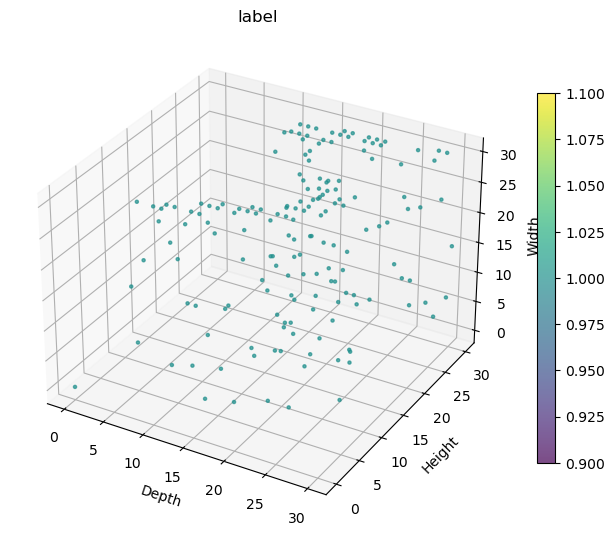

In [122]:
import numpy as np

def voxelize_point_cloud(point_cloud, grid_size):
    
    D, H, W = grid_size
    voxel_grid = np.zeros((1, D, H, W)) 
   
    min_coords = np.min(point_cloud, axis=0)
    max_coords = np.max(point_cloud, axis=0)
    normalized_points = (point_cloud - min_coords) / (max_coords - min_coords + 1e-6)  
    voxel_indices = (normalized_points * (np.array(grid_size) - 1)).astype(int)
    
    for point in voxel_indices:
        x, y, z = point
        if 0 <= x < D and 0 <= y < H and 0 <= z < W:  
            voxel_grid[0, x, y, z] = 1  
    
    return voxel_grid

point_cloud = single_datapoint['points']
voxel_input = voxelize_point_cloud(point_cloud, (32, 32, 32))
print("Voxel grid shape:", voxel_input.shape) 
visualize_4d_tensor(voxel_input,"label",0.0)

OUTPUT SHAPE :  (1, 30, 30, 30)


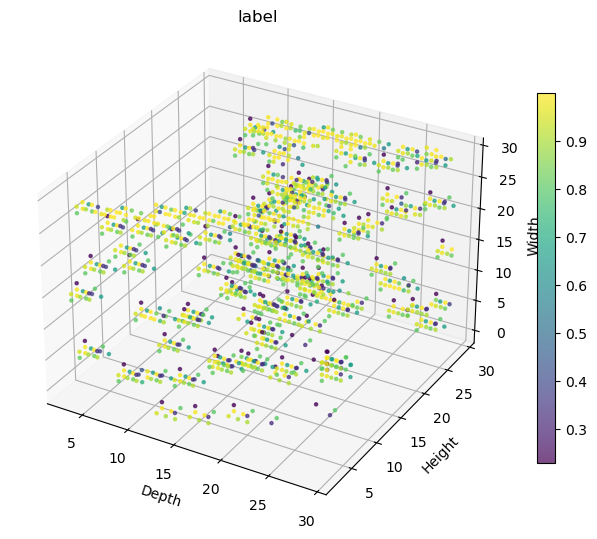

In [123]:
import numpy as np

def apply_activation(x, activation):
    if activation == 'relu':
        return np.maximum(0, x)
    elif activation == 'sigmoid':
        return 1 / (1 + np.exp(-x))
    elif activation == 'tanh':
        return np.tanh(x)
    elif activation == 'leaky_relu':
        return np.where(x > 0, x, 0.01 * x)

def conv3d(input_tensor, kernel, stride, padding,num_filters, activation):
    
    C_in, D_in, H_in, W_in = input_tensor.shape
    C_out, _, Kd, Kh, Kw = kernel.shape
    
    D_out = (D_in + 2 * padding - Kd) // stride + 1
    H_out = (H_in + 2 * padding - Kh) // stride + 1
    W_out = (W_in + 2 * padding - Kw) // stride + 1
    
   
    if padding > 0:
        input_tensor = np.pad(input_tensor, ((0, 0), (padding, padding), (padding, padding), (padding, padding)), mode='constant')
    
    output_tensor = np.zeros((C_out, D_out, H_out, W_out))
    
    for c in range(num_filters):
        for d in range(0, D_out):
            for h in range(0, H_out):
                for w in range(0, W_out):
                    
                   
                    portion = input_tensor[:, d*stride:d*stride+Kd, h*stride:h*stride+Kh, w*stride:w*stride+Kw]
                    
                    output_tensor[c, d, h, w] = np.sum(portion * kernel[c])
    
    output_tensor = apply_activation(output_tensor, activation)
    
    return output_tensor

num_filters = 1  
C_in = 2         
Kd, Kh, Kw = 3, 3, 3  

kernel = np.random.randn(num_filters, C_in, Kd, Kh, Kw)

output = conv3d(voxel_input, kernel, 1,0,1,'tanh')
print("OUTPUT SHAPE : ",output.shape)
visualize_4d_tensor(output,"label",0.2)

FOR MAX POOLING


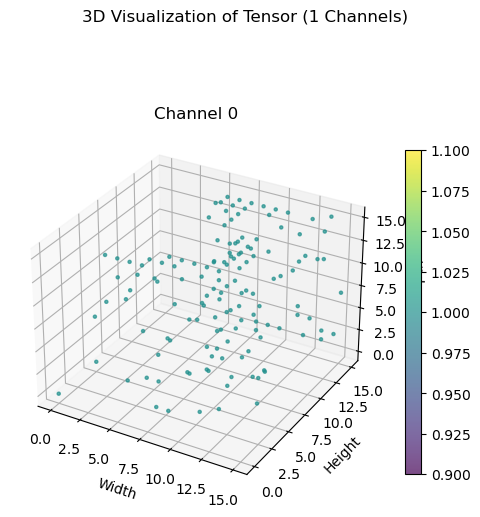

OUTPUT SHAPE :  (1, 16, 16, 16)

 
 

FOR AVG POOLING


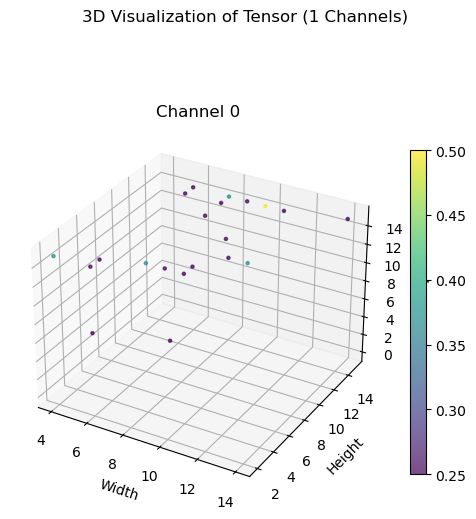

OUTPUT SHAPE :  (1, 16, 16, 16)


In [124]:
def Pooling(input_tensor, pooling_type , stride):
    C_input,D_input,H_input,W_input = input_tensor.shape
   
   
    pool_size=(2, 2, 2)
    pool_d, pool_h, pool_w = pool_size
    
    D_out = (D_input - pool_d) // stride + 1
    H_out = (H_input - pool_h) // stride + 1
    W_out = (W_input - pool_w) // stride + 1
    
    output = np.zeros((C_input, D_out, H_out, W_out))

    
    for c in range(C_input):
        for i in range(D_out):
            for j in range(H_out):
                for k in range(W_out):
                    region = input_tensor[c,
                                          i*stride:i*stride+pool_d,
                                          j*stride:j*stride+pool_h,
                                          k*stride:k*stride+pool_w]
                    if pooling_type == 'max':
                        output[c,i,j,k] = np.max(region)
                    else:
                        output[c,i,j,k] = np.mean(region)
                        
    return output

output = Pooling(voxel_input, 'max',2)
print("FOR MAX POOLING")
visualize_3d_tensor(output, label="Digit", threshold=0.2)
print("OUTPUT SHAPE : ",output.shape)
print("\n \n \n")
output = Pooling(voxel_input, "avg",2)
print("FOR AVG POOLING")
visualize_3d_tensor(output, label="Digit", threshold=0.2)
print("OUTPUT SHAPE : ",output.shape)

### 3rd question

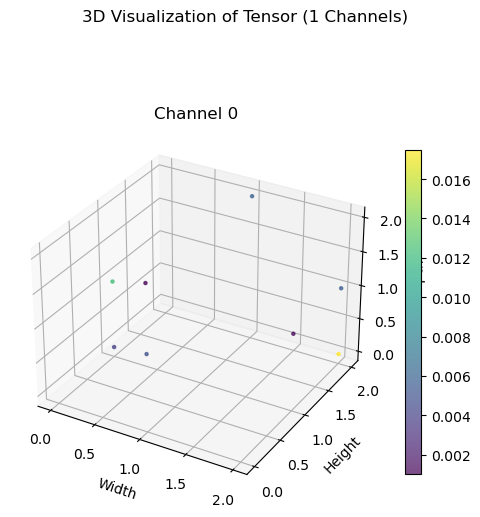

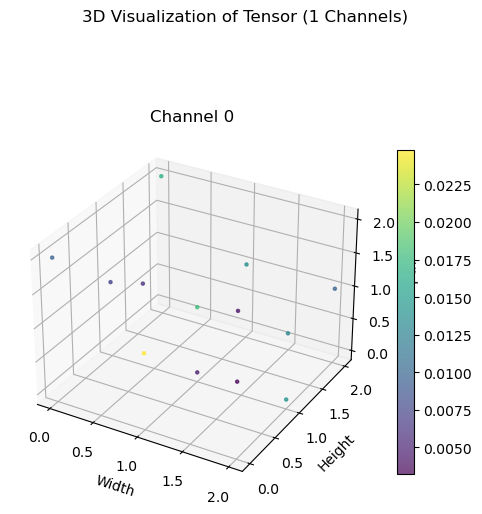

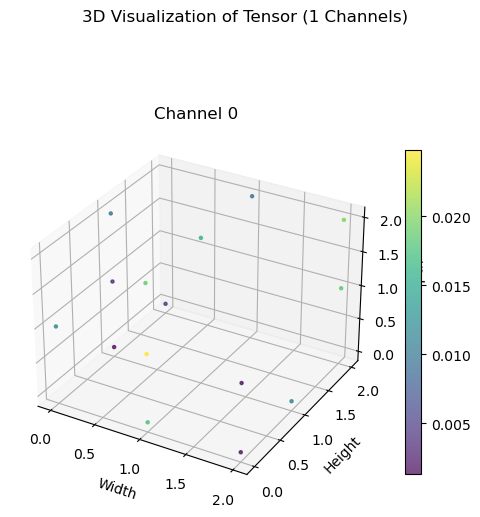

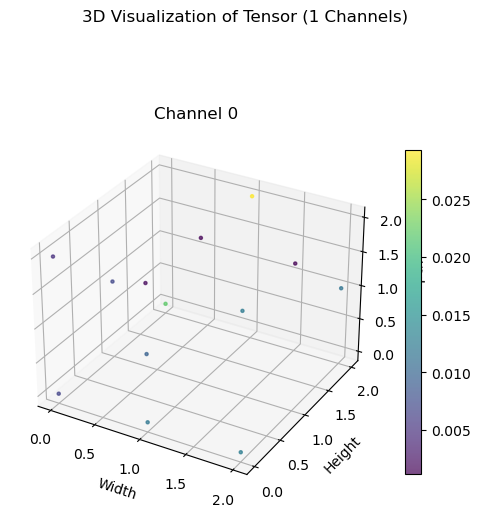

(4, 30, 30, 30)


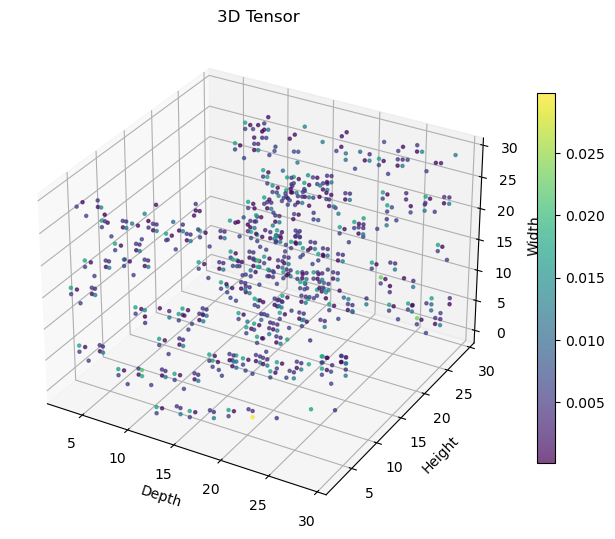

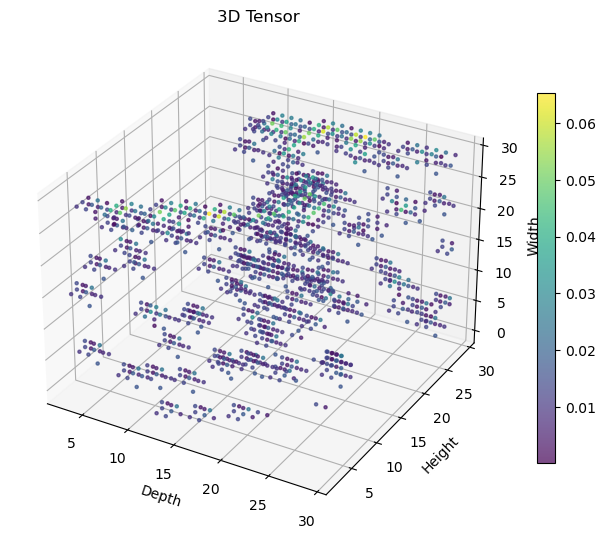

In [141]:
def conv3d_layer(input_volume, filter_kernels, stride, padding, activation):
    
    in_channels,depth, height, width = input_volume.shape
    num_filters, kernel_channels, filter_size, filter_size, filter_size = filter_kernels.shape
#     print(depth)
    filter_size = filter_kernels.shape[2]
#     print(filter_size)
    if padding > 0:
        padded_volume = np.pad(input_volume, 
                        ((0, 0), (padding, padding), (padding, padding), (padding, padding)),
                        mode='constant')

    else:
        padded_volume = input_volume
    
    out_depth = (depth + 2 * padding - filter_size) // stride + 1
    out_height = (height + 2 * padding - filter_size) // stride + 1
    out_width = (width + 2 * padding - filter_size) // stride + 1
    
   
    feature_maps = np.zeros((num_filters,out_depth, out_height, out_width))
    
    
    for f in range(num_filters):
        kernel = filter_kernels[f]
        
       
        for d in range(0, out_depth):
            for h in range(0, out_height):
                for w in range(0, out_width):
                    # Extract 3D patch from input volume
                    d_start = d * stride
                    h_start = h * stride
                    w_start = w * stride
                    d_end = d_start + filter_size
                    h_end = h_start + filter_size
                    w_end = w_start + filter_size
                    
                    patch = padded_volume[:,d_start:d_end, h_start:h_end, w_start:w_end]
                    feature_maps[f, d, h, w] = np.sum(patch * kernel)
    

    feature_maps = apply_activation(feature_maps, activation)
    #print(feature_maps.shape)
    return feature_maps

num_filters = 4
filter_kernels = np.random.randn(num_filters,1,3,3,3) * 0.01

for f in range(num_filters):
        kernel = filter_kernels[f]
        visualize_3d_tensor(kernel,label="Digit",threshold=0.0)
        
output = conv3d_layer(voxel_input, filter_kernels,1,0,'relu')
print(output.shape)
visualize_4d_tensor(output[0:1], "3D Tensor", 0.0)
visualize_4d_tensor(output[1:2], "3D Tensor", 0.0)

FOR MAX POOLING


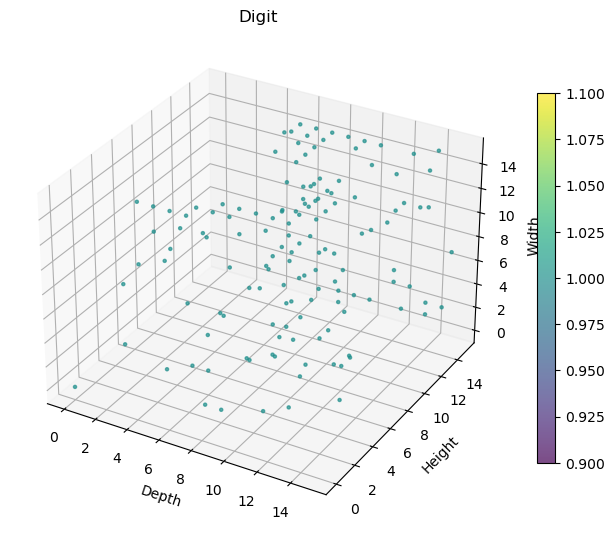

OUTPUT SHAPE :  (1, 16, 16, 16)

 
 

FOR AVG POOLING


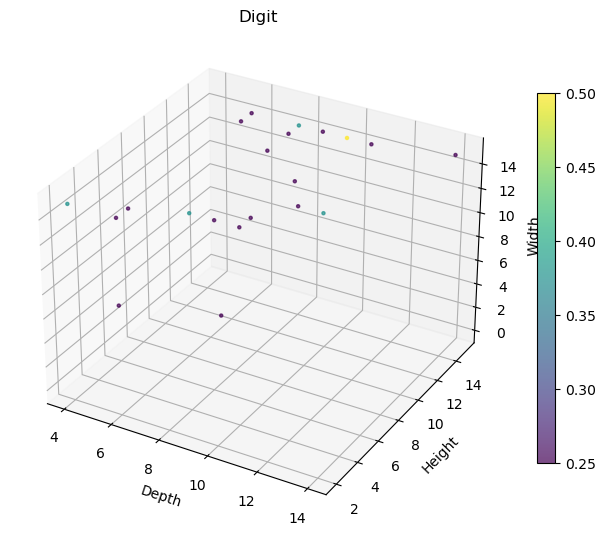

OUTPUT SHAPE :  (1, 16, 16, 16)

 
 

GAP SHAPE (1, 1, 1, 1)


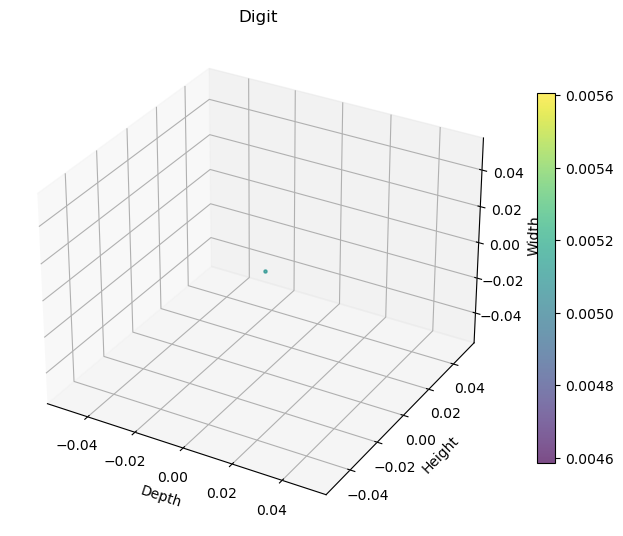

In [144]:
def pooling_3d_layer(input_tensor,pool_size, stride,pooling_type, global_pool):

    if global_pool:
        return np.mean(input_tensor, axis=(1, 2, 3), keepdims=True)  
    
    C_input,D_input,H_input,W_input = input_tensor.shape
   
   
    pool_d, pool_h, pool_w = pool_size
    
    D_out = (D_input - pool_d) // stride + 1
    H_out = (H_input - pool_h) // stride + 1
    W_out = (W_input - pool_w) // stride + 1
    
    output = np.zeros((C_input, D_out, H_out, W_out))

    
    for c in range(C_input):
        for i in range(D_out):
            for j in range(H_out):
                for k in range(W_out):
                    region = input_tensor[c,
                                          i*stride:i*stride+pool_d,
                                          j*stride:j*stride+pool_h,
                                          k*stride:k*stride+pool_w]
                    if pooling_type == 'max':
                        output[c,i,j,k] = np.max(region)
                    else:
                        output[c,i,j,k] = np.mean(region)

    return output

output = pooling_3d_layer(voxel_input,(2,2,2),2,'max', False)
print("FOR MAX POOLING")
visualize_4d_tensor(output, label="Digit", threshold=0.2)
print("OUTPUT SHAPE : ",output.shape)
print("\n \n \n")
output = pooling_3d_layer(voxel_input,(2,2,2),2,'avg', False)
print("FOR AVG POOLING")
visualize_4d_tensor(output, label="Digit", threshold=0.2)
print("OUTPUT SHAPE : ",output.shape)
print("\n \n \n")
output = pooling_3d_layer(voxel_input,(2,2,2),2,'avg', True)
print("GAP SHAPE",output.shape)
visualize_4d_tensor(output, label="Digit", threshold=0.0)


In [146]:
import numpy as np

def softmax(x):
    exp_x = np.exp(x) 
    return exp_x / exp_x.sum()

def mlp_classifier(input_vector, num_layers, activation):
    hidden_size = 128
    if len(input_vector.shape) > 1:
        input_size = np.prod(input_vector.shape)
        input_vector = input_vector.reshape(input_size)
    else:
        input_size = input_vector.shape[0]

    layer_sizes = [input_size] + [hidden_size] * num_layers + [10]

    weights = [np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01 for i in range(len(layer_sizes) - 1)]
    biases = [np.zeros(layer_sizes[i+1]) for i in range(len(layer_sizes) - 1)]

    output = input_vector
    for i in range(num_layers): 
        output = np.dot(output, weights[i]) + biases[i]

        if activation == 'relu':
            output = np.maximum(0, output)
        elif activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif activation == 'tanh':
            output = np.tanh(output)

    output = np.dot(output, weights[-1]) + biases[-1]
    output = softmax(output)

    return output



In [ ]:
def cnn_model(input_volume):
   
    filters1 = np.random.randn(16,input_volume.shape[0], 5, 5, 5)
    conv1 = conv3d_layer(input_volume, filters1, stride=1, padding=0, activation='relu')
    print(conv1.shape)
    pool1 = pooling_3d_layer(voxel_input,(2,2,2),2,'max', False)
    print(pool1.shape)
    
    filters2 = np.random.randn(32, pool1.shape[0],3, 3, 3)
    conv2 = conv3d_layer(pool1, filters2, stride=1, padding=1, activation='relu')
    print(conv2.shape)
    pool2 = pooling_3d_layer(conv2,(2, 2, 2), 2,'max',False)
    print(pool2.shape)
    
    gap_output = pooling_3d_layer(pool2,(2, 2, 2), 2,'max',True)
    
    print(gap_output.shape)
    predictions = mlp_classifier(gap_output,2,'relu')
    
    return predictions

output = cnn_model(voxel_input)
print(output.shape)
visualize_3d_tensor(output, label="Digit", threshold=0.0)

(16, 28, 28, 28)
(1, 16, 16, 16)
(32, 16, 16, 16)
(32, 8, 8, 8)
(32, 1, 1, 1)
(10,)
